# Global Black Box Optimization with RNNS
Project by Pattarawat Chormai and Felix Sattler ||
Supervised by Raphael Holca-Lamarre

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf
import gpfunctions as gp
import lstm_model
import data
import sk_optimization

## Set all the Hyperparameters

In [2]:
# Data
load_data = False
save_data = False
dim = 2
n_train = 1600
n_test = 160
n_bumps = 6
l = 2/n_bumps*np.sqrt(dim)
n_mc_samples = 1000
max_x_abs_value = 1.0
kernel = gp.rbf_kernel
function = gp.normalized_gp_function

# LSTM Model
n_hidden = 100
n_steps = 20

# Optimization
x_start = np.zeros(dim).reshape(1,dim)
epochs = 10
gradient_clipping = 1.0
forget_bias = 5.0
rate_init = 0.005
rate_final = 0.0001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 128
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "OI", "SUMIN", "WSUM_EXPO", "SUMOI", 'DIST'][3]

# Visualization
visualize = False

## Create Training Data or load from Disk

In [3]:
# Create Data or Load Data from Disk
if load_data:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = data.load_data
else:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    data.gen_data(n_train, n_test, dim, n_bumps, l, kernel, n_mc_samples)
# Save Data to Disk
if save_data:
    save_data(n_train, n_test, dim, n_bumps, l, n_mc_samples = 100)
        
data_train = (X_train, A_train, min_train, max_train)
data_test = (X_test, A_test, min_test, max_test)

In [4]:
# Visualize Training Data
if visualize: viz.plot_gp_data_sample(12, X_train, A_train, min_train, max_train, l, kernel, function)

## Compute random Baseline

In [5]:
samples_random_x, samples_random_y = sk_optimization.SKOptimizer().get_samples_sk(X_test, A_test, min_test, max_test, l, dim, \
                                                            n_steps+1, function, kernel, 10, x_start.flatten(), "random")

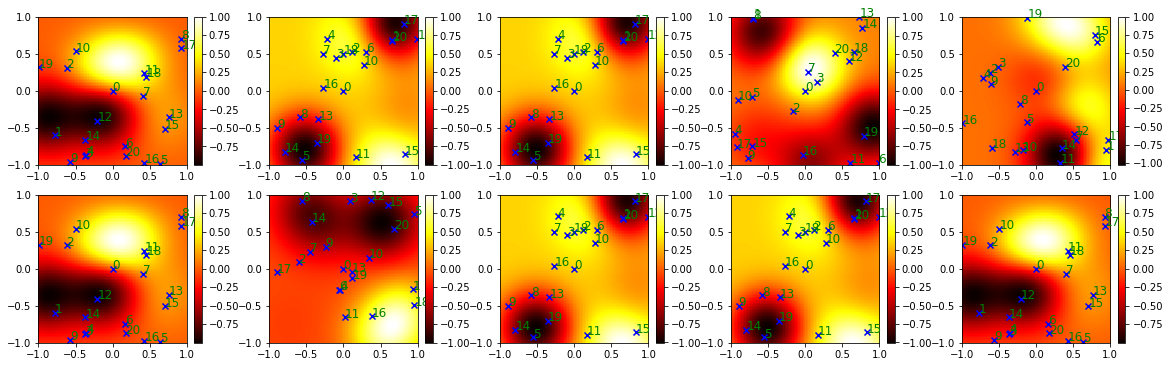

In [6]:
viz.plot_gp_results_sample(10, X_test[:10], A_test[:10], min_test[:10], \
                           max_test[:10], l, samples_random_x, samples_random_y, kernel, function)

## Compute SkOpt Baseline

In [7]:
samples_sk_x, samples_sk_y = sk_optimization.SKOptimizer().get_samples_sk(X_test, A_test, min_test, max_test, l, dim, \
                                                            n_steps+1, function, kernel, 10, x_start.flatten(), "gbrt")

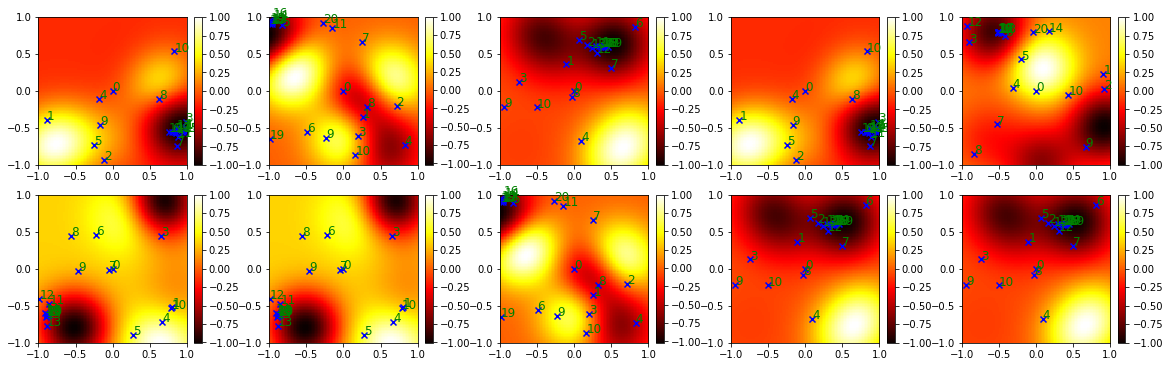

In [8]:
viz.plot_gp_results_sample(10, X_test[:10], A_test[:10], min_test[:10], \
                           max_test[:10], l, samples_sk_x, samples_sk_y, kernel, function)

## Start a Session and train the model

In [9]:
# Build the training graph, collect placeholders, sample sequence and lstmcell parameters 
Xt, At, mint, maxt, samples_x, samples_y, x_0, cell, weights = \
    lstm_model.build_training_graph(n_bumps, dim, n_hidden, forget_bias, n_steps, l, kernel, function)
placeholders = {"Xt": Xt, "At": At, "mint": mint, "maxt": maxt, "x0": x_0}

In [10]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
train_logs = lstm_model.train_model(sess, placeholders, samples_x, samples_y, epochs, batch_size, data_train, data_test,
                     rate_init, rate_decay, gradient_clipping, loss_type, x_start, max_x_abs_value, log = True)

Build Graph...
Ep:    0 | TrainLoss: -0.404 | TrainMin: -0.404 | TestLoss: -0.368 | TestMin: -0.374
Ep:    1 | TrainLoss: -0.408 | TrainMin: -0.408 | TestLoss: -0.372 | TestMin: -0.378
Ep:    2 | TrainLoss: -0.472 | TrainMin: -0.473 | TestLoss: -0.463 | TestMin: -0.469
Ep:    3 | TrainLoss: -0.522 | TrainMin: -0.522 | TestLoss: -0.476 | TestMin: -0.482
Ep:    4 | TrainLoss: -0.528 | TrainMin: -0.528 | TestLoss: -0.512 | TestMin: -0.518
Ep:    5 | TrainLoss: -0.510 | TrainMin: -0.510 | TestLoss: -0.542 | TestMin: -0.548
Ep:    6 | TrainLoss: -0.418 | TrainMin: -0.488 | TestLoss: -0.456 | TestMin: -0.533
Ep:    7 | TrainLoss: -0.494 | TrainMin: -0.494 | TestLoss: -0.531 | TestMin: -0.538
Ep:    8 | TrainLoss: -0.494 | TrainMin: -0.494 | TestLoss: -0.525 | TestMin: -0.531
Ep:    9 | TrainLoss: -0.491 | TrainMin: -0.494 | TestLoss: -0.518 | TestMin: -0.527
Done.


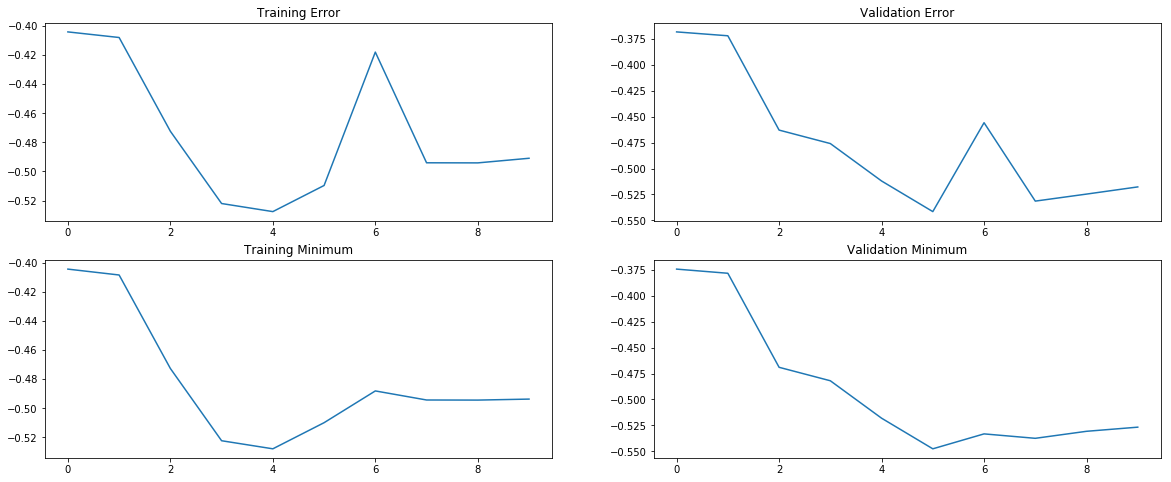

In [12]:
viz.visualize_learning(train_logs)

## Evaluate the Model on Training Data

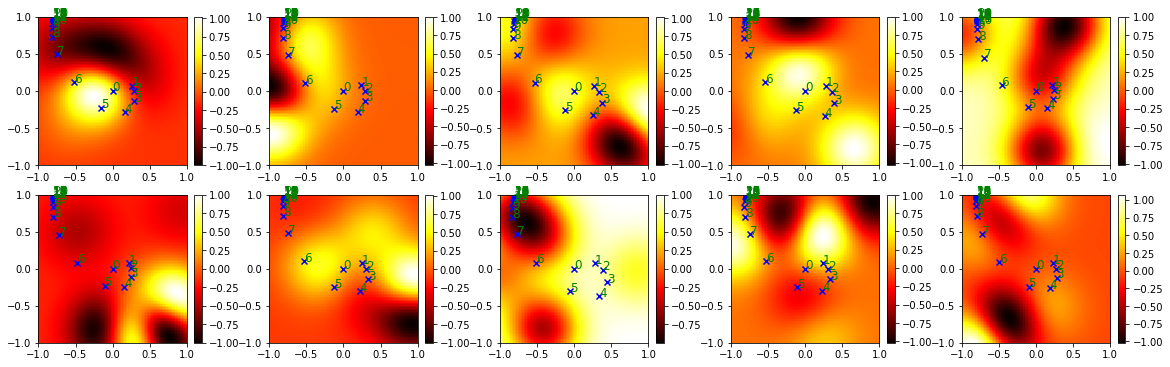

In [13]:
# Show results on Training Data
samples_train_x, samples_train_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_train, x_start)
    
viz.plot_gp_results_sample(10, X_train, A_train, min_train, max_train, l, samples_train_x, samples_train_y, kernel, function)

In [37]:
#print(samples_train_x[0], samples_train_y[0])

yyy = function("np", X_train[np.newaxis, 0], A_train[np.newaxis, 0], min_train[np.newaxis, 0], 
               max_train[np.newaxis, 0], l, kernel, samples_train_x[np.newaxis, 0])

print(samples_train_y[0])
print(yyy)

print(samples_train_x.shape)

[ 0.19502294 -0.07644862 -0.25020897 -0.35359627 -0.23453271 -0.03839636
  0.34783149  0.28036845  0.48146164  0.63681102  0.70118821  0.72318304
  0.72974193  0.73097241  0.7304318   0.72941101  0.7283771   0.72748768
  0.72678411  0.72626424  0.72591162]
[[ 0.19502302 -0.07644859 -0.25020891 -0.35359624 -0.23453258 -0.03839632
   0.34783158  0.28036837  0.48146159  0.63681097  0.70118822  0.72318307
   0.72974191  0.73097256  0.73043182  0.7294111   0.72837703  0.72748764
   0.72678414  0.72626451  0.72591172]]
(1600, 21, 2)


## Evaluate the Model on Test Data

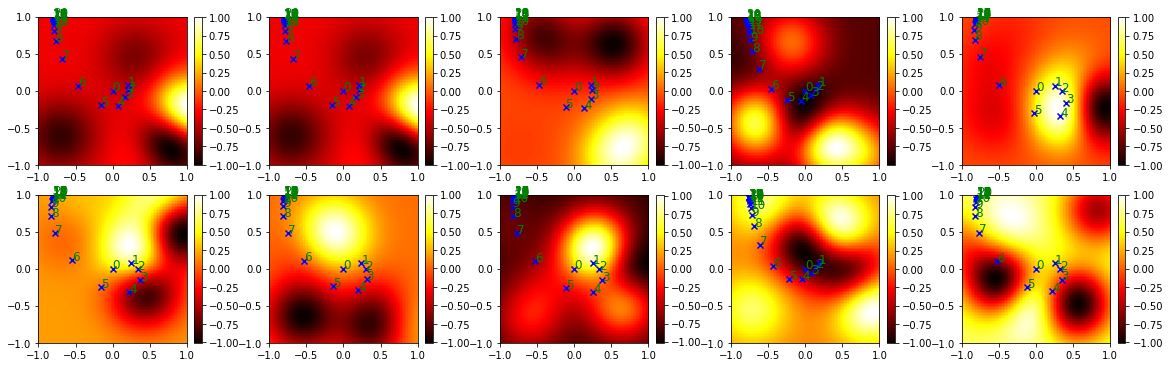

In [39]:
# Show results on Test Data
samples_test_x, samples_test_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_test, x_start)

viz.plot_gp_results_sample(10, X_test, A_test, min_test, max_test, l, samples_test_x, samples_test_y, kernel, function)

In [41]:
#print(samples_train_x[0], samples_train_y[0])

yyy = function("np", X_test[np.newaxis, 0], A_test[np.newaxis, 0], min_test[np.newaxis, 0], 
               max_test[np.newaxis, 0], l, kernel, samples_test_x[np.newaxis, 0])

print(samples_test_y[0])
print(yyy)

[ 0.36780214  0.37740898  0.34012032  0.3102988   0.31799865  0.19867671
  0.33280087  0.3657099   0.36498415  0.36468351  0.36460495  0.36455655
  0.36450505  0.36445189  0.36440372  0.36436379  0.36433232  0.36430812
  0.36428988  0.36427617  0.36426616]
[[ 0.36780212  0.37740898  0.34012027  0.31029881  0.31799864  0.19867666
   0.33280083  0.36570994  0.36498416  0.3646835   0.36460501  0.36455663
   0.36450515  0.36445198  0.36440373  0.36436379  0.36433236  0.36430822
   0.36428994  0.36427626  0.36426611]]


## Compare Results

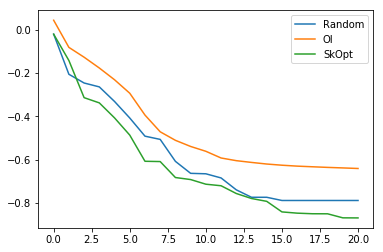

In [15]:
viz.plot_min_curves([np.array(samples_random_y), samples_test_y, np.array(samples_sk_y)],['Random','OI','SkOpt'])

## Evaluate the Model on Benchmark Functions

In [16]:
f_bm = [bf.branin, bf.goldstein_price, bf.hartmann3, bf.hartmann6][1]
f_bm_tf = [bf.branin_tf, bf.goldstein_price_tf, bf.hartmann3_tf, bf.hartmann6_tf][1]

In [17]:
samples_benchmark_x, samples_benchmark_y = \
        lstm_model.get_benchmark_samples(sess, f_bm_tf, cell, weights, dim, n_hidden, n_steps, x_start)

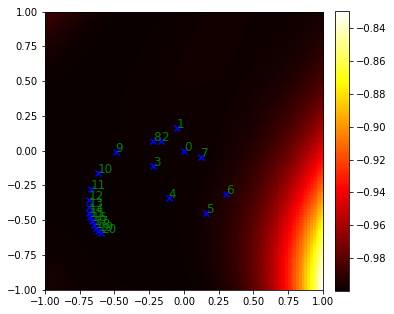

In [18]:
viz.plot_result(f_bm, dim, 1, samples_benchmark_x, samples_benchmark_y)

## Generate Sequence of sample points sequentially

In [19]:
def get_y(x):
    # Can be any arbitrary function that gets a (1,dim) numpy array as input and returns a (1,1) numpy array
    return np.sum(x**2).reshape(1,1)-1

def generate_sample_sequence(x0, steps):
    h_0 = tf.zeros([1, n_hidden])
    c_0 = tf.zeros([1, n_hidden])

    x = tf.constant(x0, dtype=tf.float32)
    state = (c_0, h_0)

    y0 = get_y(x0)
    y = tf.constant(y0, dtype=tf.float32)
    
    samples_x = [x0]
    samples_y = [y0]
    
    for i in range(steps):
        x, state = lstm_model.next_sample_point(x,y,state,cell,weights, scope="rnn_cell")
        x_np = sess.run(x)
        y_np = get_y(x_np)
        y = tf.constant(y_np, dtype=tf.float32)
        
        samples_x += [x_np]
        samples_y += [y_np]
        
    return samples_x, samples_y

In [20]:
samples_x, samples_y = generate_sample_sequence(np.ones([1,dim]), steps = 20)

In [21]:
samples_y

[array([[ 1.]]),
 array([[-0.86431456]], dtype=float32),
 array([[-0.82191384]], dtype=float32),
 array([[-0.73631275]], dtype=float32),
 array([[-0.68164444]], dtype=float32),
 array([[-0.58375645]], dtype=float32),
 array([[-0.29670411]], dtype=float32),
 array([[-0.49503928]], dtype=float32),
 array([[-0.81331497]], dtype=float32),
 array([[-0.71406031]], dtype=float32),
 array([[-0.53149152]], dtype=float32),
 array([[-0.40559566]], dtype=float32),
 array([[-0.32820374]], dtype=float32),
 array([[-0.28031486]], dtype=float32),
 array([[-0.24626935]], dtype=float32),
 array([[-0.22082305]], dtype=float32),
 array([[-0.20317614]], dtype=float32),
 array([[-0.19252062]], dtype=float32),
 array([[-0.1873408]], dtype=float32),
 array([[-0.18610489]], dtype=float32),
 array([[-0.18765187]], dtype=float32)]